from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from functools import partial

In [2]:
SEED = 420

## Loading the data in pandas dataframe

In [3]:
# Load the datasets
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print("Train Size - ", len(train_df))
print("Test Size - ", len(test_df))

Train Size -  120000
Test Size -  7600


In [4]:
# Display the first few rows
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Preprocessing steps

In [5]:
# analyze the class distribution
print(train_df['Class Index'].value_counts())

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


In [6]:
# check for missing values
print(train_df.isnull().sum())

Class Index    0
Title          0
Description    0
dtype: int64


In [7]:
# Precossing function
# we are removing sentences with len < max_len_raw and len > min_len_raw
# lowering the case of each sentence

def get_proc_df(data_path, max_len_raw = 64, min_len_raw = 32):
    df = pd.read_csv(data_path)
    df['Description'] = df.Description.str.replace('/', '').str.replace ('  ', ' ')

    seperator_char = " "
    
    del_index = []
    for i, row in enumerate (df.iterrows ()) : 
        df.loc[i, 'Description'] = df.loc[i, 'Title'].lower() + seperator_char + df.loc[i, 'Description'].lower()
        df.loc[i, 'length'] = len(df.loc[i, 'Description'].split())

        # ignoring samples with "length" > max_len_raw and < min_len_raw
        if df.loc[i, 'length'] > max_len_raw or df.loc[i, 'length'] < min_len_raw:
            del_index.append(i)
            
    df.drop(index = del_index, inplace = True)
    
    return df

In [8]:
train_proc_df = get_proc_df("data/train.csv", max_len_raw = 80, min_len_raw = 5)
test_proc_df = get_proc_df("data/test.csv", max_len_raw = 80, min_len_raw = 5)

print("Train Size - ", len(train_proc_df))
print("Test Size - ", len(test_proc_df))

Train Size -  119405
Test Size -  7565


In [9]:
# check for missing values
print(train_proc_df.isnull().sum())

Class Index    0
Title          0
Description    0
length         0
dtype: int64


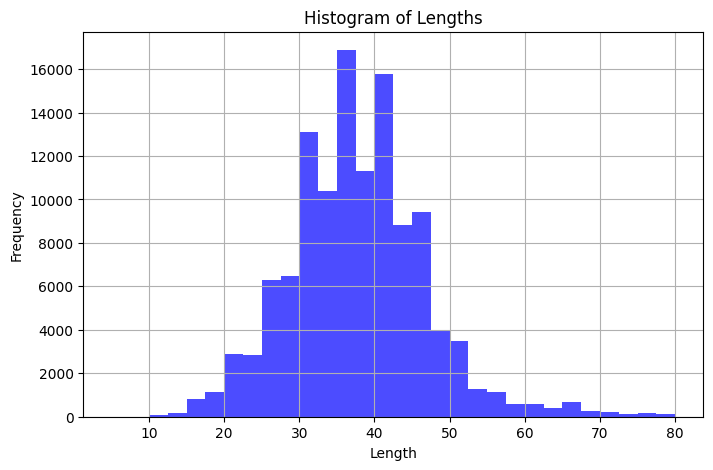

In [10]:
# analyse lengths of train_proc_df
plt.figure(figsize = (8, 5))
plt.hist(train_proc_df['length'], bins = 30, alpha = 0.7, color = 'blue')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Train / valid split (data prep)

In [11]:
# Splitting the training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_proc_df['Description'], 
    train_proc_df['Class Index'], 
    test_size = 0.1, # Adjust this to change the validation set size
    stratify = train_proc_df['Class Index'],
    random_state = SEED,
)

## Dataset definition

In [13]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
        self.encodings = []
        for text in tqdm(texts, desc = "Tokenising data"):
            self.encodings.append(tokenizer.encode(
                                                text,
                                                truncation = True,
                                                padding = False,
                                                max_length = self.max_len,
                                    ))
    

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, item):
        input_ids = torch.tensor(self.encodings[item])
        return {
            'input_ids': input_ids,
            'attention_mask': torch.ones_like(input_ids),
            'labels': torch.tensor(self.labels[item], dtype = torch.long)
        }

# padding collator
def dynamic_padding_collator(batch, pad_token_id):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids_padded = pad_sequence(input_ids, batch_first = True, padding_value = pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first = True, padding_value = 0)
    
    labels = torch.stack(labels)
    
    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

In [14]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

## Create dataloaders

In [15]:
# Define max sequence length
MAX_LEN = 512

# Create datasets
train_dataset = NewsDataset(
    texts = train_texts.to_list(),
    labels = train_labels.to_numpy(),
    tokenizer = tokenizer,
    max_len = MAX_LEN
)

val_dataset = NewsDataset(
    texts = val_texts.to_list(),
    labels = val_labels.to_numpy(),
    tokenizer = tokenizer,
    max_len = MAX_LEN,
)

test_dataset = NewsDataset(
    texts = test_proc_df['Description'].to_list(),
    labels = test_proc_df['Class Index'].to_numpy(),
    tokenizer = tokenizer,
    max_len = MAX_LEN,
)

batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = partial(dynamic_padding_collator, pad_token_id = tokenizer.pad_token_id), num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = batch_size, collate_fn = partial(dynamic_padding_collator, pad_token_id = tokenizer.pad_token_id), num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, collate_fn = partial(dynamic_padding_collator, pad_token_id = tokenizer.pad_token_id), num_workers = 2)

Tokenising data: 100%|████████████████████████████████████████████████████████████████████████████| 7565/7565 [00:02<00:00, 3732.81it/s]


## Model definition

In [12]:
MODEL_NAME = 'bert-base-uncased'

In [16]:
class BERT_CLS(nn.Module):
    def __init__ (self, dropout = 0.1, num_classes = 4, freeze_transformer = False):
        super(BERT_CLS, self).__init__ ()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # freeze BERT parameters
        if freeze_transformer:
            for param in self.bert.parameters():
                param.requires_grad = False
            
        self.dropout = nn.Dropout(p = dropout)
        self.linear = nn.Linear(768, num_classes)
    
    def forward(self, input_ids, attention_mask):
        # using the model's pooler output
        _, output = self.bert(input_ids = input_ids, attention_mask = attention_mask, return_dict = False)
        output = self.dropout(output)
        output = self.linear(output)
        return output

In [17]:
model = BERT_CLS()

## Evaluation

In [18]:
def evaluate_model(model, data_loader, device):
    model.eval()

    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device) - 1

            outputs = model(input_ids, attention_mask)

            _, preds = torch.max(outputs, dim = 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

            del batch, input_ids, attention_mask, labels, outputs, preds
            torch.cuda.empty_cache()

    # calculate metrics (Precision, Recall, F1 score, Accuracy)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average = 'weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Training Loop

In [19]:
epochs = 5

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-6)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

In [21]:
device = "cuda"

model = model.to(device)

for epoch in range(epochs):
    model.train()
    
    total_loss = 0
    for batch in tqdm(train_loader, desc = f"Training Epoch {epoch + 1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device) - 1
        
        outputs = model(input_ids, attention_mask)
        
        loss = criterion(outputs, labels)
        
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # cache clearance
        del batch, input_ids, attention_mask, labels, outputs
        torch.cuda.empty_cache()
    
    print(f"Epoch {epoch + 1}, TRAIN Loss: {total_loss / len(train_loader)}")
    valid_metrics = evaluate_model(model, val_loader, device)
    print("VALID Accuracy -", valid_metrics["accuracy"])

Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████| 3359/3359 [07:26<00:00,  7.53it/s]

Epoch 1, TRAIN Loss: 0.2658241270248642


VALID Accuracy - 0.9233732518214555


Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████| 3359/3359 [07:26<00:00,  7.52it/s]

Epoch 2, TRAIN Loss: 0.19195951751468526


VALID Accuracy - 0.9280629763001423


Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████| 3359/3359 [07:22<00:00,  7.59it/s]

Epoch 3, TRAIN Loss: 0.1749201730657818


VALID Accuracy - 0.9190185076626748


Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████| 3359/3359 [07:31<00:00,  7.44it/s]

Epoch 4, TRAIN Loss: 0.20365991075136416


VALID Accuracy - 0.8433129553638724


Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████| 3359/3359 [07:23<00:00,  7.58it/s]

Epoch 5, TRAIN Loss: 0.15393806642060587


VALID Accuracy - 0.9227870362616196


In [22]:
# evalaute on test set
test_metrics = evaluate_model(model, test_loader, device)
print(test_metrics)

{'accuracy': 0.9204230006609385, 'precision': 0.9215130761026911, 'recall': 0.9204230006609385, 'f1': 0.920460404583035}
